# Regresión

Supongamos que deseamos aproximar una función arbitrariamente $f(x)$ haciendo uso de un perceptrón multicapa.  ¿En qué modo afecta el número de neuronas en la capa intermedia a la calidad de la aproximación?

Propongamos como ejemplo la función de una dimensión:
\begin{align}
  f(x) = x \text{sen}(x) - x \text{cos}(x/3)
\end{align}

In [1]:
import numpy as np

In [2]:
def f(x):
    """
    Función objetivo.
    Intentaremos que un perceptrón multicapa la aproxime.
    """
    return x * np.sin(x) - x * np.cos(x/3)

In [3]:
# Rango de valores a estudiar
x = np.arange(-20, 20, 0.1)
y = f(x)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0, 0.5, '$y$')

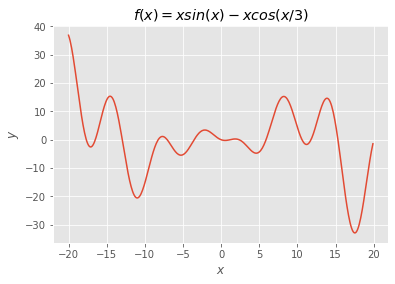

In [5]:
# Visualización de la función objetivo
plt.plot(x, y)
plt.title('$f(x) = x sin(x) - x cos(x/3)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

In [6]:
# Instalar pyTorch según:
# https://pytorch.org/get-started/locally/
# Elegir versión.
# Ej: Para ejecutar desde aquí versión para cpu descomentar
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [7]:
import torch
from torch import nn

In [8]:
# Vector 1D a matriz columna
x_vec = np.reshape(x, (len(x),1))    # Arreglo de numpy
x_vec.dtype

dtype('float64')

In [9]:
# Matriz de numpy a tensor de pyTorch
X = torch.tensor(x_vec.astype(np.float32))  # Tensor 1D
X.dtype

torch.float32

In [10]:
# Vector de salidas esperadas
y_vec = np.reshape(y, (len(y),1))
Y = torch.tensor(y_vec.astype(np.float32))  # Tensor 1D

In [11]:
class NeuralNetwork(nn.Module):
    """
    Red neuronal de tres capas.
    Las capas intermedias utilizan una sigmoide como función de activación.
    La capa final sólo calcula la combinación lineal, pues la sigmoide no
    puede salir del rango [0,1], para este problema de regresión no es
    adecuada.
    """
    def __init__(self, s1):
        """
        param s1: Número de neuronas en la capa oculta
        """
        super(NeuralNetwork, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(1, s1, bias=False),
            nn.Sigmoid(),
            nn.Linear(s1, 1, bias=False)
        )
        
    def forward(self, x):
        """
        Evaluación de la red sobre la entrada x
        usando alimentación hacia adelante para los pesos
        actuales.
        """
        logits = self.layers_stack(x)
        return logits

In [12]:
def train(X, Y, model, learning_rate, num_steps):
    """
    Función que realiza el entrenamiento:
    Intentará reducir la distancia entre los valores que salen
    de la red y lo que deseamos modificando los pesos de la red.
    """
    size = len(X)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    step_report = 100
    num_reports = int(num_steps/step_report)
    print(num_reports)
    e = np.zeros(num_reports)
    for i in range(num_steps):
        # Predicción y error
        Y_hat = model(X)
        loss = loss_fn(Y_hat, Y)
        
        # Reduciendo el error
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Cómo vamos
        if i % step_report == 0:
            num_report = int(i/step_report)
            e[num_report] = loss.item()
            #print(f"{num_report} loss: {loss:>7f}")
    #plt.plot(e)
    return Y_hat, e

In [13]:
# Versión interactiva
from ipywidgets import interact_manual
import ipywidgets as widgets

In [14]:
learning_rates = {2: 0.025, 5: 0.0015, 50:0.001, 500:0.0005, 5000:0.0001}
num_steps = {2: 4000, 5: 17000, 50: 10000, 500: 10000, 5000: 10000}
@interact_manual(
    s1 = widgets.SelectionSlider(
        options = [2,5,50,500,5000]
    )
)
def aproxima(s1):
    learning_rate = learning_rates[s1]
    n_steps = num_steps[s1]
    model = NeuralNetwork(s1)
    y_pred, e = train(X, Y, model, learning_rate, n_steps)
    y_pred = y_pred.detach().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(np.arange(len(e))*100,e)
    axes[1].plot(x, y_pred)

interactive(children=(SelectionSlider(description='s1', options=(2, 5, 50, 500, 5000), value=2), Button(descri…